# CC Scheme

In [12]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
from obspy import UTCDateTime, read_inventory
import os
import xcorr
import dask
from dask.diagnostics import ProgressBar

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
client = xcorr.Client(sds_root='/Users/psmets/Documents/Research/_data/WaveformArchive')

In [14]:
# general parameters
sampling_rate = 50.
window_length = 86400. # 24h
window_overlap = 21./24. # 3h shift
clip_lag = pd.to_timedelta((0,6),unit='h')
poi = {'name': 'MVC', 'latitude': -25.887, 'longitude': -177.188, 'elevation': 0., 'local_depth': 132.}

attrs = {
    'title': 'Monowai Volcanic Centre',
    'institution': 'Delft University of Technology, Department of Geoscience and Engineering',
    'author': 'Pieter Smets - P.S.M.Smets@tudelft.nl',
    'source': 'CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data',
}

# stream preprocess operations (sequential!)
preprocess = {
    'BHZ': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        # ('running_rms', {}),
    ],
    'BHR': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('rotate', {'method':'->ZNE'}),
        ('rotate', {'method':'NE->RT', 'back_azimuth':250.39 }),
        ('select', {'channel':'BHR'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        # ('running_rms', {}),
    ],
    'EDH': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_sensitivity', {}),
        # ('remove_response', {}),
        ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
        ('decimate', { 'factor': 5 }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        # ('running_rms', {}),
    ],
}

In [15]:
def filename(pair:str,time:pd.datetime):
    return '{pair}.{y:04d}.{d:03d}.nc'.format(pair=pair,y=time.year,d=time.dayofyear)
dest = '/Users/psmets/Documents/Research/_studies/_hydro/monowai_remote/tests/full'

In [16]:
pairs = [
    'IM.H10N1..EDH-IU.RAR.10.BHZ',
    'IM.H10N1..EDH-IU.RAR.10.BHR',
    'IM.H03S1..EDH-IU.RAR.10.BHZ',
    'IM.H03S1..EDH-IU.RAR.10.BHR',
]
times = pd.date_range('2015-01-15', '2015-01-20', freq='1D')

inv = xcorr.util.get_pair_inventory(pairs, read_inventory('Monowai.xml'), times)

In [19]:
status = client.init_data_availability(pairs, times, extend_days=1, substitute=False)
delayed_status = client.verify_data_availability(status, download=False, compute=False)

In [20]:
with ProgressBar():
    verified = delayed_status.compute()

[########################################] | 100% Completed |  5.1s


In [8]:
def xcorr_process(
    pair, time, **kwargs
):
        
    ncfile = os.path.join(dest, pair, filename(pair, time))
        
    # Try to open first
    ds = xcorr.read(ncfile, fast=True)
        
    # Exists and anything to update?
    if ds and np.all(ds.status.values == 1):
        ds.close()
        return True
        
    # Create a new dataset
    if not ds:
        ds = xcorr.init(
            pair=pair,
            starttime=time,
            endtime=time + pd.offsets.DateOffset(1), 
            attrs=attrs,
            preprocess=preprocess, 
            sampling_rate=sampling_rate, 
            window_length=window_length, 
            window_overlap=window_overlap, 
            clip_lag=clip_lag,
            unbiased_cc=False,
            inventory=inv,
            stationary_poi=poi,
        )
            
    # Process
    xcorr.process(
        ds,
        inventory=inv.select(
            starttime=UTCDateTime(time),
            endtime=UTCDateTime(time + pd.offsets.DateOffset(1))
        ),
        client=client,
        retry_missing=True,
        download=False,
        verb=0,
        **kwargs
    )
    
    # To disk
    if ds and np.any(ds.status.values != 0):
        xcorr.write(ds, ncfile, verb=0)
        
    return True

In [9]:
process_list = []
for pair in pairs:
    receivers = xcorr.util.split_pair(pair, substitute=True, to_dict=False)
    for time in times:
        availability = status.loc[{
            'receiver': receivers,
            'time':pd.date_range(
                start=time - pd.offsets.DateOffset(seconds=window_length/2, normalize=True),
                end=time + pd.offsets.DateOffset(seconds=window_length*3/2, normalize=True),
                freq=times.freqstr
            )
        }] == 1
        
        # all receivers required for any day
        if any(availability.sum(dim='receiver') == len(receivers)):
            process_list.append(
                dask.delayed(xcorr_process)(pair, time, test_run=True)
                )
delayed_process = dask.delayed(sum)(process_list)

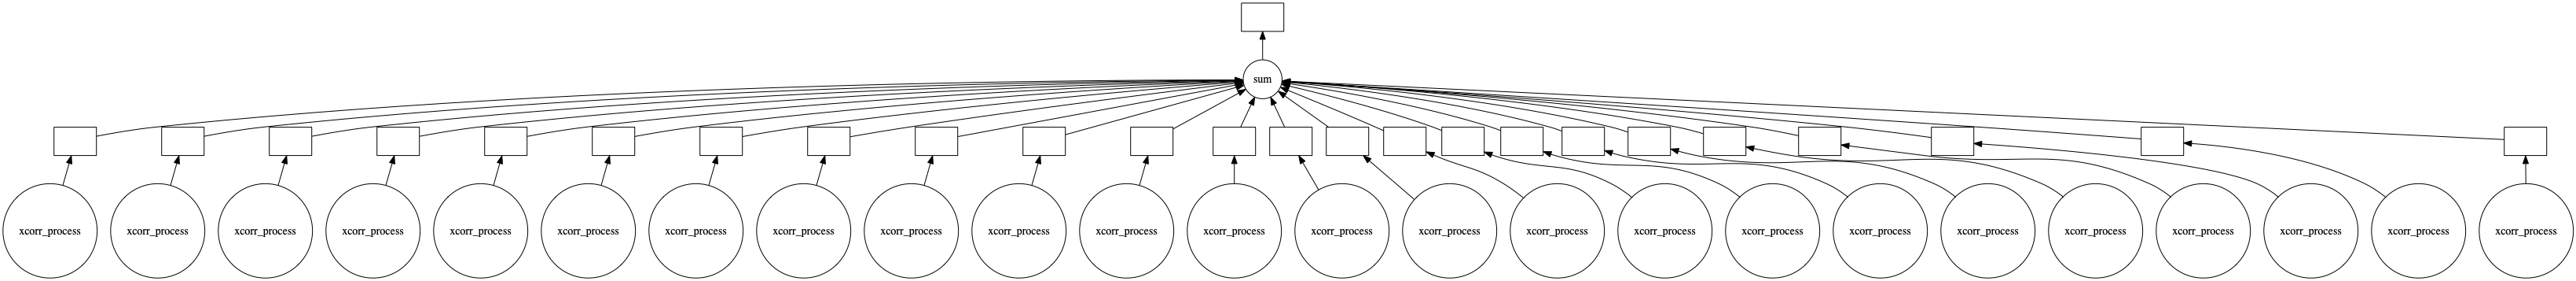

In [10]:
delayed_process.visualize()

In [11]:
with ProgressBar():
    completed = delayed_process.compute()

[########################################] | 100% Completed | 24min  6.3s


In [35]:
ls

Monowai.xml           xcorr analysis.ipynb  xcorr dask.ipynb
mydask.png            xcorr cc.ipynb        xcorr merge.ipynb
test.nc               xcorr client.ipynb
